# Image Downloader

In [2]:
import pandas as pd 
import urllib
import urllib2
import ssl # SSLError
import  requests # t SSLError
from urllib2 import URLError
from urlparse import urlparse
import os
from pyprind import ProgBar
import socket
import sys
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from pymongo import MongoClient

ImportError: No module named 'urllib3'

## Load cvs file containing urls 

In [34]:
#Load URL List
df = pd.read_csv('image_urls.csv')
image_urls = pd.Series(df['image_url']).dropna()
urls = image_urls[ image_urls.str.startswith("htt")]
print("Valid Urls starting with \"htt*\" " + str(len(urls)) + 
      " from a total of "+ str(len(df)) + " in csv file") 
df.info()

Valid Urls starting with "htt*" 76987 from a total of 83933 in csv file
<class 'pandas.core.frame.DataFrame'>
Int64Index: 83933 entries, 0 to 83932
Data columns (total 7 columns):
media_source             83933 non-null object
pub_date                 83933 non-null object
image_url                83909 non-null object
image_width              6487 non-null object
image_height             4026 non-null object
mediacloud_stories_id    83933 non-null int64
story_url                83933 non-null object
dtypes: int64(1), object(6)
memory usage: 5.1+ MB


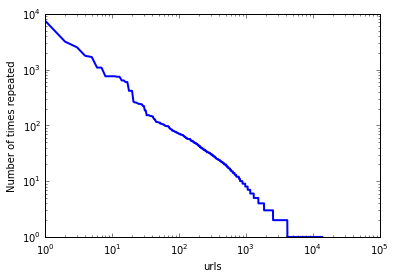

Repetition histogram

first 10 values data ploted above: 
[7555 7555 3158 2511 1759 1680 1085 1083  758  758]
('Unique links:', 13842)
('links found at most 10 times, should be photos ', 13023)
('links found at least 10 times, spacers, logos, etc ..', 819)


In [46]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
image_urls_counts = image_urls.value_counts()
line, = ax.plot(image_urls_counts .values, color='blue', lw=2)
ax.set_yscale('log')
ax.set_ylabel("Number of times repeated")
ax.set_xscale('log')
ax.set_xlabel("urls")
plt.show()
print("Repetition histogram")
print("")
print("first 10 values data ploted above: ")
print(image_urls_counts[:10].values)
print("Unique links:", len(image_urls.dropna().unique())) 
print("links found at most 10 times, should be photos ", 
      len(image_urls_counts [image_urls_counts<=10]))
print("links found at least 10 times, spacers, logos, etc ..",
      len(image_urls_counts [image_urls_counts>10])) 

In [47]:
#Removed Urls repeated more than 10 times
val_counts = urls.value_counts()
repetition_dict = {url:repeted for url,repeted in val_counts.iteritems()}
url_list = [url for url in urls if repetition_dict[url] <= 10]
urls = pd.Series(url_list)
print("Remaining url after we remove urls repeated 10 times: ", len(urls))

('Remaining url after we remove urls repeated 10 times: ', 21046)


In [48]:
#Remove Files already loaded
files =  os.listdir("img")
down_urls =  map(urllib2.unquote, files)
print("Files downloaded: ", len(down_urls))
print(urls.isin(down_urls).value_counts())
remaining = urls[~urls.isin(down_urls)] #remaining = pd.read_csv('test.csv') # testing with a couple of files
print("Remaining: ", len(remaining), "Downloaded files removed:", len(down_urls))
remaining = pd.Series(remaining)

('Files downloaded: ', 12063)
True     19119
False     1927
dtype: int64
('Remaining: ', 1927, 'Downloaded files removed:', 12063)


In [49]:
#Removing unvalid extensions
exts =  [os.path.splitext(p)[1] for p in remaining] #croping text before "."
exts =  [ext.split('?')[0]  for ext in exts] #removing text after extension
exts =  [ext.split('&')[0]  for ext in exts] #removing text after extension
exts =  [ext.split('%')[0]  for ext in exts] #removing text after extension
valid = pd.Series(exts)
v = valid.isin(['.jpg', '.gif' ,'.png', '.jpeg','.JPG'])
remaining = remaining[list(valid.isin(['.jpg', '.gif' ,'.png', '.jpeg','.JPG']))] # what we keep
print("Remaining", len(remaining), "after unvalid extensions removed")

('Remaining', 729, 'after unvalid extensions removed')


In [9]:
# Downloading images
bar = ProgBar(len(remaining), monitor=True)
unfetchables = []
timeouts = []
urlerrors = []
large_names = []

for i, image_name in enumerate(remaining):
    bar.update(item_id = image_name, force_flush=True)
    img =  None
    try:
        img = urllib2.urlopen(image_name, None, 0.5).read()
    except (URLError, requests.exceptions.SSLError, ssl.SSLError) as e:
        urlerrors.append((image_name,e))
        #print("URLError:   ",e ,image_name)
        continue
    except socket.timeout as e:
        timeouts.append((image_name, e))
        #print("Timed out!", e, image_name)
        continue
    except Exception as e:
        unfetchables.append((image_name, e))
        print("Unknow exception", e, image_name)
        continue
    filename = urllib2.quote(image_name, safe="")
    if len(filename) > 250:
        large_names.append(filename)
        filename = 'L' + filename[:250]
        #print("Name too long"+filename)
    if img:
        f = open("img/" + filename,'wb')
        f.write(img)
        f.close()
print("urlerros", len(urlerrors), "timeouts", len(timeouts), 
      "unfetchables", len(unfetchables), "large names", len(large_names))

('Files to download: ', 76987)
('Remaining after removed repeated 10: ', 21046)
('Files downloaded: ', 11595)
True     18950
False     2096
dtype: int64
('Remaining: ', 2096, 'Downloaded files removed:', 11595)


0%                          100%
[                              ] | ETA: 00:01:16 | Item ID: http://static01.nyt.com/images/2015/11/20/us/why-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249/why-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249-master495-v5.png

('Remaining', 898, 'after unvalid extensions removed')


[##############################] | ETA: 00:00:00 | Item ID: https://i.guim.co.uk/img/media/9f52b7012ad3ae3e729373e696407c10dea5cd57/123_30_2694_1617/master/2694.jpg?w=300&q=85&auto=format&sharp=10&s=f681edb76cb05dab82f737b93946ef23

('unfechables', 0, 'large_names', 615)



Total time elapsed: 00:03:50


In [10]:
print(len(urlerrors), len(timeouts), len(unfetchables), len(large_names))

(112, 2, 0, 615)


# Scratch Pad

In [82]:
# Discarting malformed Urls
df = pd.read_csv('image_urls.csv')
urls = df['image_url'].dropna()
malformed = urls[ urls.str.contains("img.youtube.com")]
malformed_urls =  urls[ urls.str.startswith("htt")]
print(df.shape, urls.shape, urls.unique().shape, malformed_urls.unique().shape)

((83933, 7), (83909,), (13842,), (13777,))


In [96]:
#Checking images height and width
import pandas as pd
d = pd.read_csv('test.csv')
print(d.shape)
print("** width **")
print(d['image_width'].describe())
print("** height **")
print(d['image_height'].describe())
rows_with_width = [ r for r, v in enumerate(d['image_width'].notnull()) if v]
rows_with_height = [ r for r, v in enumerate(d['image_height'].notnull()) if v]
print("rows_with_width", len(rows_with_width))
print("rows_with_height", len(rows_with_height))
print("rows_with_height and rows_with_height",len(set(rows_with_width+rows_with_height)))

(6, 7)
** width **
count     0
mean    NaN
std     NaN
min     NaN
25%     NaN
50%     NaN
75%     NaN
max     NaN
Name: image_width, dtype: float64
** height **
count     0
mean    NaN
std     NaN
min     NaN
25%     NaN
50%     NaN
75%     NaN
max     NaN
Name: image_height, dtype: float64
('rows_with_width', 0)
('rows_with_height', 0)
('rows_with_height and rows_with_height', 0)


### Extension Extraction


In [121]:
d = pd.read_csv('image_urls.csv')
paths = [ urlparse(name).path for name in d['image_url'].dropna()]
exts =  [os.path.splitext(p)[1] for p in paths]
ext = pd.Series(exts, dtype='category')
ext.unique()
ext.value_counts()
len(ext)

### Duplicate Name Handling 

In [158]:
# unquoting image names
urls = df['image_url'].dropna()
files = [ f for f in os.listdir("img")]
down_urls =  map(urllib.unquote, files)
remaining = urls[~urls.isin(down_urls)]
remaining.shape


(83458,)

In [ ]:
%ls 
#name = 'http://static01.nyt.com/images/2014/11/12/opinion/krugman-circular/krugman-circular-thumbLarge-v4.png'
name = 'http%3A%2F%2Fstatic01.nyt.com%2Fimages%2F2015%2F11%2F20%2Fus%2Fwhy-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249%2Fwhy-it-takes-two-years-for-syrian-refugees-to-apply-to-enter-the-united-states-1448050604249-master495-v5.png'
real_name = urllib.unquote(name)
url2 = urllib.url2pathname(name)
url_quote = urllib.quote(name, safe="")
print(url2)
print(url_quote)
#f = open('img/'+ url_quote, 'wb')
#f = open("img/test", 'wb')

import base64
a = real_name
b = real_name.encode('zlib')
c = base64.urlsafe_b64encode(real_name.encode('zlib'))

a,b,c,len(a),len(b),len(c)
# crop_index = 255 - len(urlsafe_base64encode(zlib encode))) 
# name = quote_name(file_name)[crop_index:]+ safeseparator + encoded name